### PCA

With the elbow method, we determine that the number of components is 3.

In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [77]:
df = pd.read_csv("/content/merged_df.csv")
df

,year-month,gas_value,monthly_ev_sales_with_noise,stock_price_close,stations_number,number_of_licensed_drivers,electricity_price
0,2014-01,3.39200,0.000000,0.000000,5948.0,2.140925e+08,0.134
1,2014-02,3.43425,0.000000,0.000000,6094.0,2.144251e+08,0.134
2,2014-03,3.60580,0.000000,0.000000,6307.0,2.147578e+08,0.135
3,2014-04,3.73525,0.000000,0.000000,6474.0,2.150905e+08,0.131
4,2014-05,3.75000,0.000000,0.000000,6646.0,2.154231e+08,0.136
...,...,...,...,...,...,...,...
124,2024-05,3.72525,3751.709677,66.255455,200997.0,0.000000e+00,0.175
125,2024-06,3.57550,3987.533333,69.565789,204406.0,0.000000e+00,0.178
126,2024-07,3.60040,0.000000,68.798182,207548.0,0.000000e+00,0.178
127,2024-08,3.50650,0.000000,69.747273,212726.0,0.000000e+00,0.177


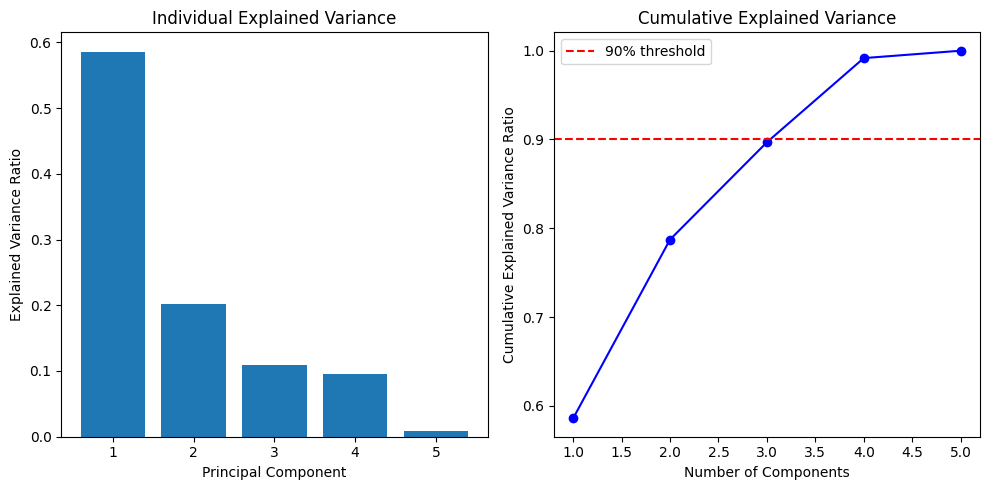

PC1: 0.586 (0.586 cumulative)
PC2: 0.201 (0.787 cumulative)
PC3: 0.110 (0.897 cumulative)
PC4: 0.095 (0.992 cumulative)
PC5: 0.008 (1.000 cumulative)


In [78]:
features = ['gas_value', 'stock_price_close',
           'stations_number', 'number_of_licensed_drivers', 'electricity_price']

# Prepare the data
X = df[features]
X_scaled = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Print the explained variance ratios
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f} ({cumulative_variance[i]:.3f} cumulative)")

In [79]:
X = df[features]
X_scaled = StandardScaler().fit_transform(X)

# Initialize and fit PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2', 'PC3'],
    index=df.index
)

# Add the original date column if needed
pca_df['year-month'] = df['year-month']

# Get the feature loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=features
)

# Print feature loadings
print("Feature loadings:")
print(loadings)
print("\nExplained variance ratio by component:")
print(pca.explained_variance_ratio_)

Feature loadings:
                                 PC1       PC2       PC3
gas_value                   0.408292  0.364834  0.827348
stock_price_close           0.484612 -0.331323 -0.110266
stations_number             0.564809  0.059896 -0.189283
number_of_licensed_drivers -0.321367  0.713983 -0.108330
electricity_price           0.419718  0.493723 -0.505740

Explained variance ratio by component:
[0.58592027 0.20133828 0.10962625]


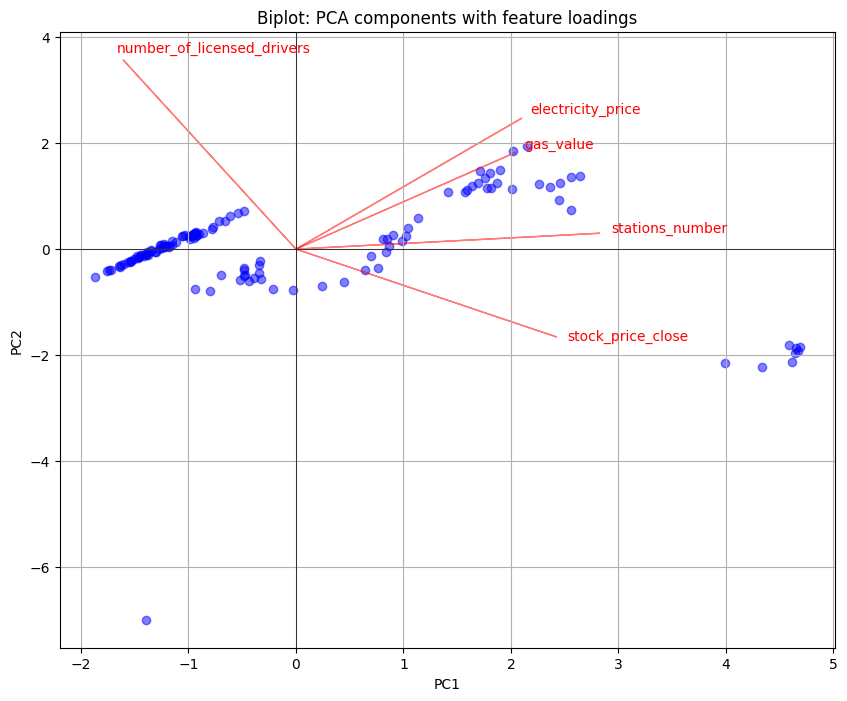

In [80]:
# Create a biplot of the first two components
import matplotlib.pyplot as plt

def biplot(score, coef, labels=None):
    plt.figure(figsize=(10, 8))

    # Plot scores (transformed data)
    xs = score[:,0]
    ys = score[:,1]
    plt.scatter(xs, ys, c='b', alpha=0.5)

    # Plot feature loadings
    for i, (x, y) in enumerate(zip(coef[:,0], coef[:,1])):
        plt.arrow(0, 0, x*5, y*5, color='r', alpha=0.5)
        if labels is not None:
            plt.text(x*5.2, y*5.2, labels[i], color='r')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Biplot: PCA components with feature loadings')
    plt.grid()
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    plt.show()

biplot(X_pca[:, 0:2], loadings.iloc[:, 0:2].values, features)

# Save transformed data
pca_df.to_csv('pca_transformed_data.csv', index=False)


### Random Forest

In [81]:
# Do PCA
def prepare_data(df):
    features = ['gas_value', 'stock_price_close', 'stations_number',
                'number_of_licensed_drivers', 'electricity_price']
    X = df[features]
    y = df['monthly_ev_sales_with_noise']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=3)  # Using 3 components based on previous analysis
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, y, pca, scaler

# Function to evaluate predictions
def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

In [82]:
# Train-Test Split (last 20% as test)
def simple_backtest(X, y):
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return evaluate_predictions(y_test, y_pred)

# Run all backtests
X_pca, y, pca, scaler = prepare_data(df)

# Train-Test Split
simple_results = simple_backtest(X_pca, y)
print("Train-Test Split Results:")
print(pd.DataFrame([simple_results]))


Train-Test Split Results:
          RMSE          MAE        R2
0  1448.803783  1332.982245 -0.773567


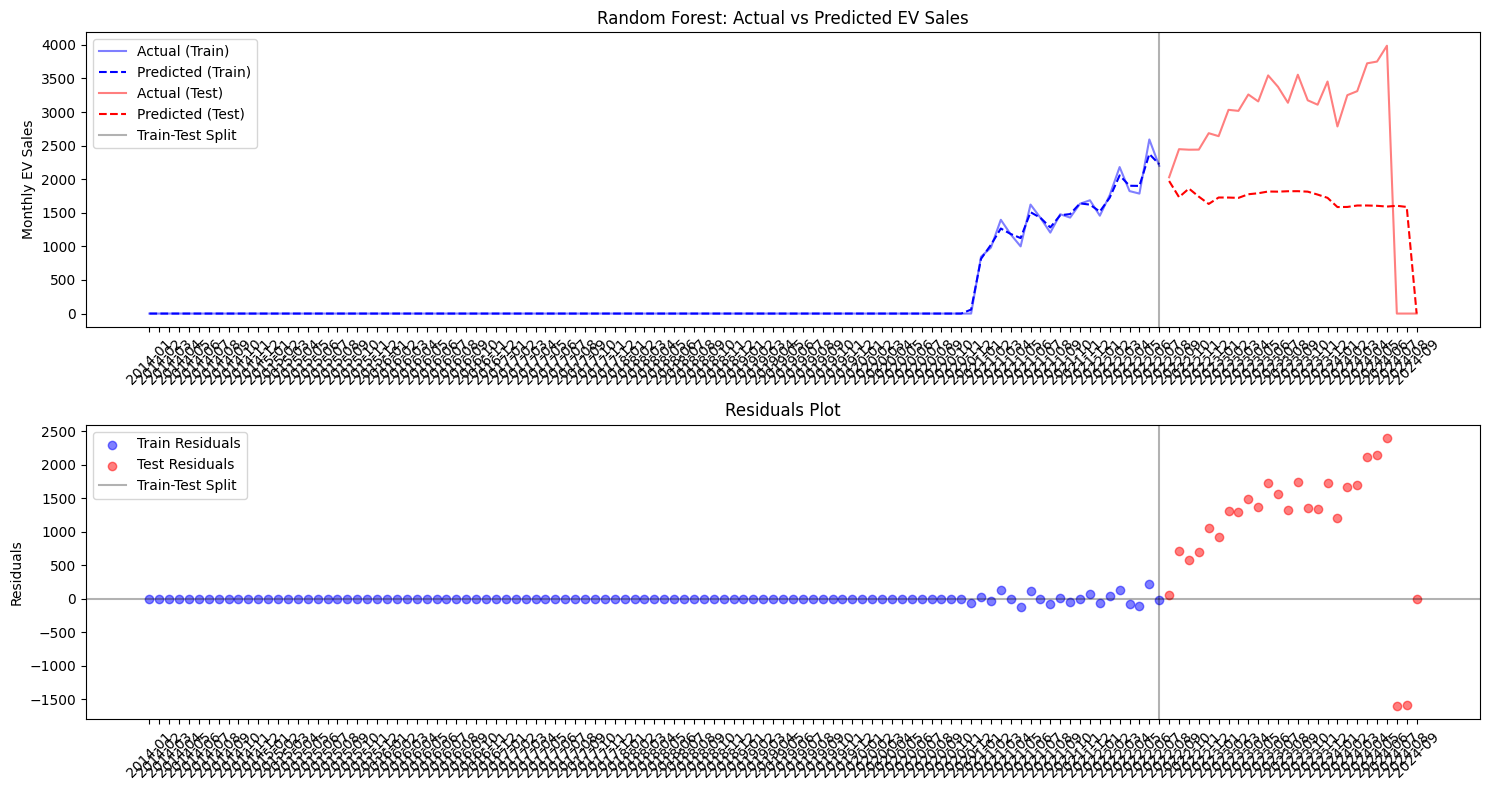


Detailed Metrics:

Training Set Metrics:
RMSE: 38.38
R²: 1.00

Test Set Metrics:
RMSE: 1448.80
R²: -0.77


In [83]:
# Get predictions for both training and test sets
split_idx = int(len(X_pca) * 0.8)
X_train, X_test = X_pca[:split_idx], X_pca[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create timeline for x-axis
train_dates = df['year-month'][:split_idx]
test_dates = df['year-month'][split_idx:]

# Create the visualization
plt.figure(figsize=(15, 8))

# Plot actual vs predicted values
plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train, label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(train_dates, y_train_pred, label='Predicted (Train)', color='blue', linestyle='--')
plt.plot(test_dates, y_test, label='Actual (Test)', color='red', alpha=0.5)
plt.plot(test_dates, y_test_pred, label='Predicted (Test)', color='red', linestyle='--')
plt.axvline(x=train_dates.iloc[-1], color='black', linestyle='-', alpha=0.3, label='Train-Test Split')
plt.title('Random Forest: Actual vs Predicted EV Sales')
plt.ylabel('Monthly EV Sales')
plt.legend()
plt.xticks(rotation=45)

# Plot residuals
plt.subplot(2, 1, 2)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.scatter(train_dates, train_residuals, label='Train Residuals', alpha=0.5, color='blue')
plt.scatter(test_dates, test_residuals, label='Test Residuals', alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=train_dates.iloc[-1], color='black', linestyle='-', alpha=0.3, label='Train-Test Split')
plt.title('Residuals Plot')
plt.ylabel('Residuals')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print some additional metrics
print("\nDetailed Metrics:")
print("\nTraining Set Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"R²: {r2_score(y_train, y_train_pred):.2f}")

print("\nTest Set Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_test_pred):.2f}")

Due to significant shifts in EV sales patterns, we found that data before August 2020 did not effectively predict recent sales trends. Therefore, we limited our analysis to data collected after August 2020.

Train-Test Split Results:
          RMSE          MAE        R2
0  1478.399953  1020.606844  0.165575


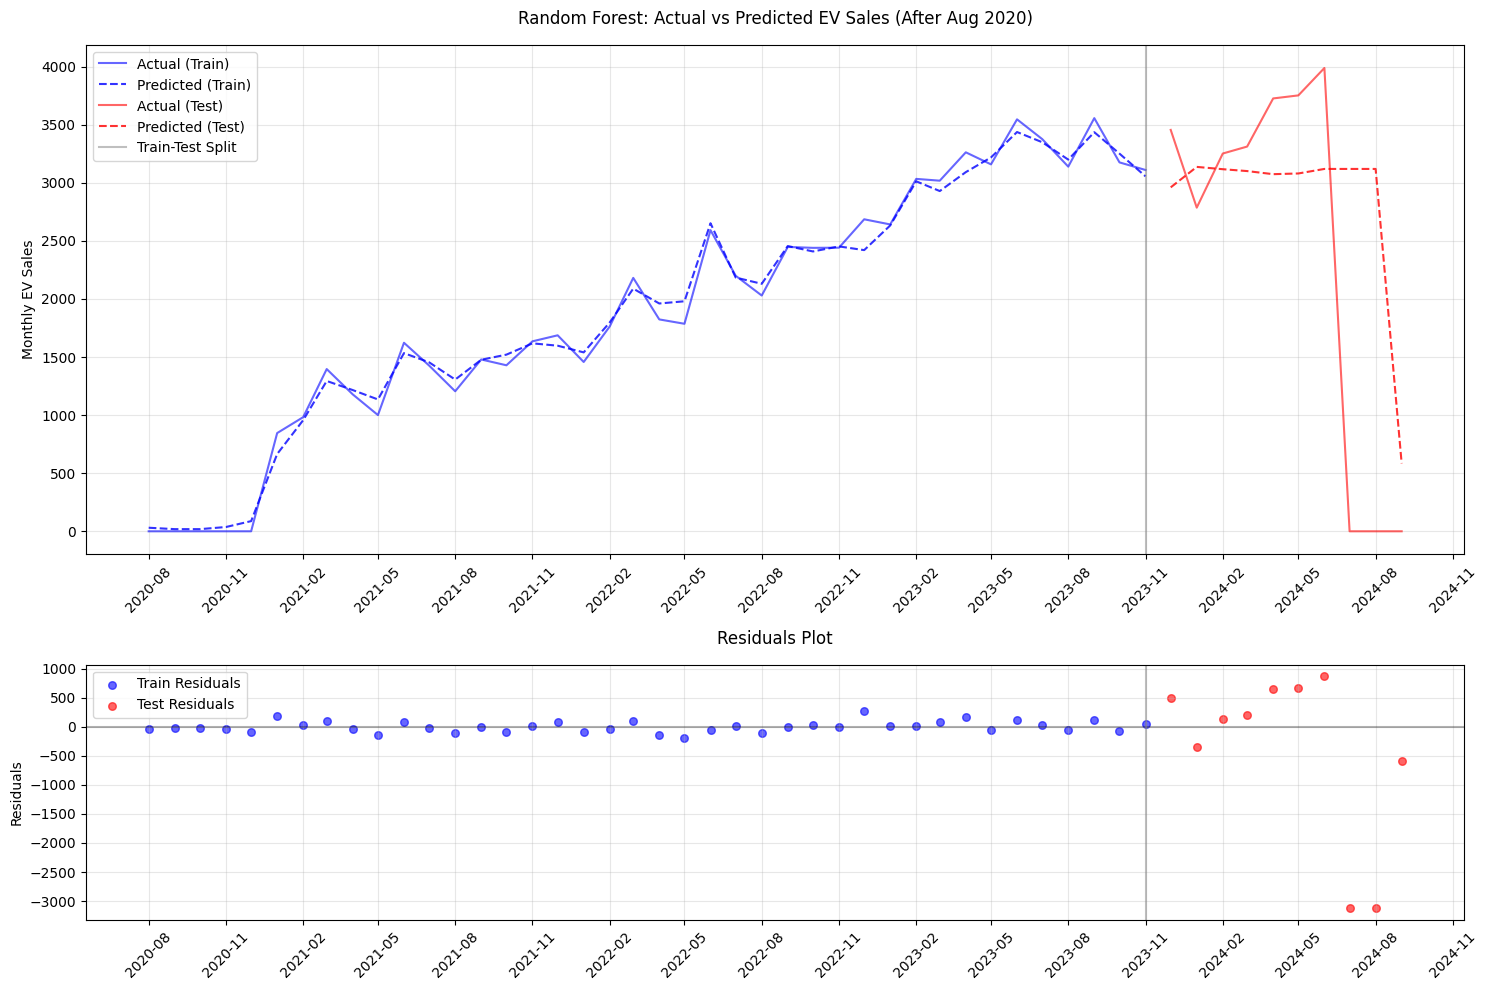


Detailed Metrics:

Training Set (After Aug 2020):
RMSE: 93.33
R²: 0.99

Test Set:
RMSE: 1478.40
R²: 0.17

Mean Absolute Percentage Error (MAPE) on test set: 13.52%


In [84]:
# Prepare the data with date filtering
def prepare_data(df):
    # Convert year-month to datetime
    df['date'] = pd.to_datetime(df['year-month'])

    # Filter for dates after August 2020
    cutoff_date = pd.to_datetime('2020-08')
    df_filtered = df[df['date'] >= cutoff_date].copy()

    # Select features for PCA
    features = ['gas_value', 'stock_price_close', 'stations_number',
                'number_of_licensed_drivers', 'electricity_price']
    X = df_filtered[features]
    y = df_filtered['monthly_ev_sales_with_noise']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, y, pca, scaler, df_filtered['date']

# Modified simple backtest function
def simple_backtest(X, y, dates):
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get training predictions for visualization
    y_train_pred = model.predict(X_train)

    results = evaluate_predictions(y_test, y_pred)

    return {
        'metrics': results,
        'predictions': {
            'train_dates': dates_train,
            'test_dates': dates_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_train_pred': y_train_pred,
            'y_test_pred': y_pred
        }
    }

# Run the analysis
X_pca, y, pca, scaler, dates = prepare_data(df)
results = simple_backtest(X_pca, y, dates)

# Print metrics
print("Train-Test Split Results:")
print(pd.DataFrame([results['metrics']]))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])

# Extract prediction data
pred_data = results['predictions']

# Plot 1: Actual vs Predicted
ax1.plot(pred_data['train_dates'], pred_data['y_train'],
         label='Actual (Train)', color='blue', alpha=0.6)
ax1.plot(pred_data['train_dates'], pred_data['y_train_pred'],
         label='Predicted (Train)', color='blue', linestyle='--', alpha=0.8)
ax1.plot(pred_data['test_dates'], pred_data['y_test'],
         label='Actual (Test)', color='red', alpha=0.6)
ax1.plot(pred_data['test_dates'], pred_data['y_test_pred'],
         label='Predicted (Test)', color='red', linestyle='--', alpha=0.8)

# Add train-test split line
split_date = pred_data['train_dates'].iloc[-1]
ax1.axvline(x=split_date, color='gray', linestyle='-', alpha=0.5, label='Train-Test Split')

# Configure first plot
ax1.set_title('Random Forest: Actual vs Predicted EV Sales (After Aug 2020)', pad=15)
ax1.set_ylabel('Monthly EV Sales')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Residuals
train_residuals = pred_data['y_train'] - pred_data['y_train_pred']
test_residuals = pred_data['y_test'] - pred_data['y_test_pred']

ax2.scatter(pred_data['train_dates'], train_residuals,
            label='Train Residuals', alpha=0.6, color='blue', s=30)
ax2.scatter(pred_data['test_dates'], test_residuals,
            label='Test Residuals', alpha=0.6, color='red', s=30)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axvline(x=split_date, color='gray', linestyle='-', alpha=0.5)

# Configure second plot
ax2.set_title('Residuals Plot', pad=15)
ax2.set_ylabel('Residuals')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Additional metrics
train_rmse = np.sqrt(mean_squared_error(pred_data['y_train'], pred_data['y_train_pred']))
train_r2 = r2_score(pred_data['y_train'], pred_data['y_train_pred'])
test_rmse = np.sqrt(mean_squared_error(pred_data['y_test'], pred_data['y_test_pred']))
test_r2 = r2_score(pred_data['y_test'], pred_data['y_test_pred'])

print("\nDetailed Metrics:")
print(f"\nTraining Set (After Aug 2020):")
print(f"RMSE: {train_rmse:.2f}")
print(f"R²: {train_r2:.2f}")

print(f"\nTest Set:")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.2f}")

mape = np.mean(np.abs((pred_data['y_test'] - pred_data['y_test_pred']) /
                      pred_data['y_test'][pred_data['y_test'] != 0])) * 100
print(f"\nMean Absolute Percentage Error (MAPE) on test set: {mape:.2f}%")